# Creating your own dataset from Google Images

*adapted from a notebook by [Francisco Ingham and Jeremy Howard](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb). Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

In this tutorial we will see how to easily create an image dataset through Google Images. 

## Get a list of URLs

**Note**: You will have to repeat these steps for any new category you want to Google (e.g once for dogs and once for cats).

### Search and scroll

Go to [Google Images](http://images.google.com) and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

It is a good idea to put things you want to exclude into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

    "canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis

You can also limit your results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.

### Download into file

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Press `Ctrl`-`Shift`-`J` in Windows/Linux and `Cmd`-`Opt`-`J` in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. You can do this by running the following commands (you might want to change `urls.txt` to `your_class_name.txt`):

```javascript
javascript:document.body.innerHTML = `<a href="data:text/csv;charset=utf-8,${escape(Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou).join('\n'))}" download="urls.txt">download urls</a>`;
```

### Upload urls file into your server

In the left panel, select `Files`, click on `UPLOAD` and choose your file with urls. Make sure names of your url files are formatted as `your_class_name.txt`.

## Download images

In [1]:
from fastai.vision import *
import os, shutil

First, let us create a list of your classes and check that everything is as it is supposed to be. 

In [2]:
# you need to change classes to your classes
classes = ['konvalinka','kopretina','pampeliska']

for class_name in classes:
  assert os.path.isfile(class_name + '.txt')
  

If everything is ok, create a folder for each class and copy url files into them.

In [3]:
data_folder = Path('data/')

for class_name in classes:
  class_folder = data_folder/class_name
  class_folder.mkdir(parents=True, exist_ok=True)
  shutil.copy(class_name + '.txt', class_folder)


Now you will need to download your images from their respective urls.

fast.ai has a function that allows you to do just that. You just have to specify the urls filename as well as the destination folder and this function will download and save all images that can be opened. If they have some problem in being opened, they will not be saved.

Let's download our images! Notice you can choose a maximum number of images to be downloaded. In this case we will not download all the urls.

You will need to run this line once for every category.

In [6]:
for class_folder in classes:
    print(class_folder)
    file_name = class_folder + ".txt"
    download_images(data_folder/class_folder/file_name, data_folder/class_folder, max_pics=195)

pampeliska


Then we can remove any images that can't be opened:

In [7]:
for class_folder in classes:
    print(class_folder)
    verify_images(data_folder/class_folder, delete=True, max_size=500)

konvalinka


cannot identify image file <_io.BufferedReader name='data/konvalinka/00000031.jpg'>
cannot identify image file <_io.BufferedReader name='data/konvalinka/00000187.jpg'>
cannot identify image file <_io.BufferedReader name='data/konvalinka/00000066.jpg'>
cannot identify image file <_io.BufferedReader name='data/konvalinka/00000013.jpg'>
kopretina


cannot identify image file <_io.BufferedReader name='data/kopretina/00000178.jpg'>
cannot identify image file <_io.BufferedReader name='data/kopretina/00000082.jpg'>
cannot identify image file <_io.BufferedReader name='data/kopretina/00000002.jpg'>
pampeliska


cannot identify image file <_io.BufferedReader name='data/pampeliska/00000007.jpg'>
cannot identify image file <_io.BufferedReader name='data/pampeliska/00000151.jpg'>
cannot identify image file <_io.BufferedReader name='data/pampeliska/00000121.jpg'>
cannot identify image file <_io.BufferedReader name='data/pampeliska/00000182.jpg'>


/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:1005: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry " +


int() argument must be a string, a bytes-like object or a number, not 'tuple'


## View data

In [8]:
np.random.seed(42)
data = ImageDataBunch.from_folder(data_folder, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
# If you already cleaned your data, run this cell instead of the one before
# np.random.seed(42)
# data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
#         ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

In [9]:
data.classes

['konvalinka', 'kopretina', 'pampeliska']

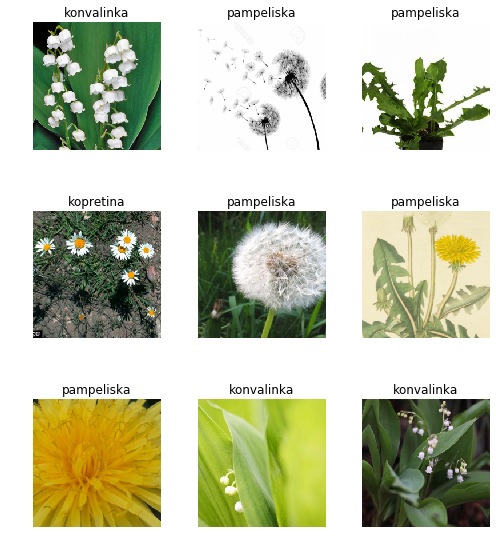

In [10]:
data.show_batch(rows=3, figsize=(7,8))

In [11]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['konvalinka', 'kopretina', 'pampeliska'], 3, 454, 113)

## Train model

In [12]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [13]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.028268,0.292814,0.079646,00:07
1,0.637467,0.157108,0.061947,00:04
2,0.458780,0.142684,0.053097,00:04
3,0.359730,0.138344,0.044248,00:04


In [14]:
learn.save('stage-1')

In [34]:
learn.load('stage-1');

In [30]:
learn.unfreeze()

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


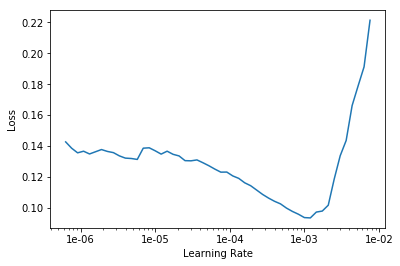

In [32]:
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(3, max_lr=slice(5e-6,5e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.146306,0.130470,0.061947,00:04
1,0.128850,0.120357,0.044248,00:04
2,0.102398,0.121726,0.053097,00:04


In [27]:
learn.save('stage-2')

## Interpretation

In [36]:
learn.load('stage-2');

In [37]:
interp = ClassificationInterpretation.from_learner(learn)

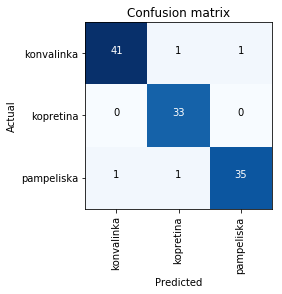

In [38]:
interp.plot_confusion_matrix()

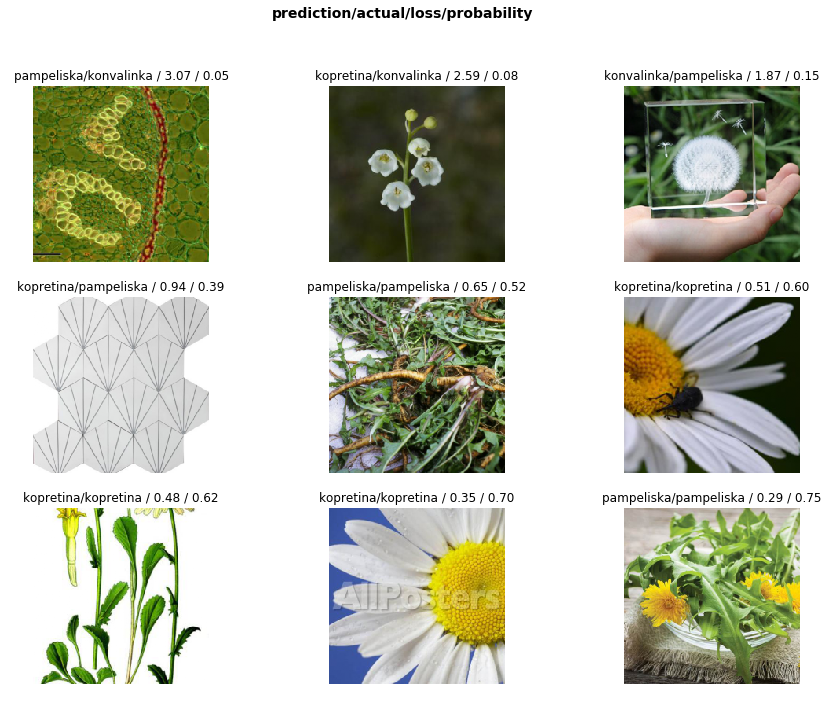

In [44]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)

## Cleaning Up - Not Working In Colab

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

In [39]:
from fastai.widgets import *

First we need to get the file paths from our top_losses. We can do this with `.from_toplosses`. We then feed the top losses indexes and corresponding dataset to `ImageCleaner`.

Notice that the widget will not delete images directly from disk but it will create a new csv file `cleaned.csv` from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

In order to clean the entire set of images, we need to create a new dataset without the split. The video lecture demostrated the use of the `ds_type` param which no longer has any effect. See [the thread](https://forums.fast.ai/t/duplicate-widget/30975/10) for more details.

In [40]:
db = (ImageList.from_folder(data_folder)
                   .no_split()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:168: UserWarning: `no_split` is deprecated, please use `split_none`.
  warn("`no_split` is deprecated, please use `split_none`.")


In [0]:
# If you already cleaned your data using indexes from `from_toplosses`,
# run this cell instead of the one before to proceed with removing duplicates.
# Otherwise all the results of the previous step would be overwritten by
# the new run of `ImageCleaner`.

# db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
#                    .no_split()
#                    .label_from_df()
#                    .transform(get_transforms(), size=224)
#                    .databunch()
#      )

Then we create a new learner to use our new databunch with all the images.

In [41]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [42]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

Make sure you're running this notebook in Jupyter Notebook, not Jupyter Lab. That is accessible via [/tree](/tree), not [/lab](/lab). Running the `ImageCleaner` widget in Jupyter Lab or Colab is [not currently supported](https://github.com/fastai/fastai/issues/1539).

In [43]:
# do not run me in colab
ImageCleaner(ds, idxs, data_folder)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. `ImageCleaner` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses.ImageCleaner(ds, idxs)`

You can also find duplicates in your dataset and delete them! To do this, you need to run `.from_similars` to get the potential duplicates' ids and then run `ImageCleaner` with `duplicates=True`. The API works in a similar way as with misclassified images: just choose the ones you want to delete and click 'Next Batch' until there are no more images left.

Make sure to recreate the databunch and `learn_cln` from the `cleaned.csv` file. Otherwise the file would be overwritten from scratch, loosing all the results from cleaning the data from toplosses.

In [0]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

In [0]:
# do not run me in Colab
ImageCleaner(ds, idxs, path, duplicates=True)

Remember to recreate your ImageDataBunch from your `cleaned.csv` to include the changes you made in your data!

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [0]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [0]:
defaults.device = torch.device('cpu')

In [0]:
img = open_image(path/'black'/'00000021.jpg')
img

We create our `Learner` in production enviromnent like this, just make sure that `path` contains the file 'export.pkl' from before.

In [0]:
learn = load_learner(path)

In [0]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

For more information about putting your model into production, see [fast.ai webpage](https://course.fast.ai/deployment_render.html).